In [1]:
# Add the root path of the pyqula library
import os ; import sys
sys.path.append(os.environ["DMRGROOT"]) # add the library via environmental variable
# you have to install the dmrgpy library from
# https://github.com/joselado/dmrgpy
# and add its address to your python path (done above with an environmental variable)

# some default parameters in matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 22
plt.rcParams['image.cmap'] = 'coolwarm'


import numpy as np

# Matrix product states for many-body fermionic models

### Learning outcomes
- Solve many-body fermionic models with tensor networks
- Understand the role of correlators in many-body fermionic models
- Rationalize phase transitions in spinless and spinful fermionic systems
- Understand spin-charge separation in the Hubbard model


## Energy of interacting spinless fermions as a function of the system size
Let us first look at the many-body energy of the Heisenberg model as function of the system size

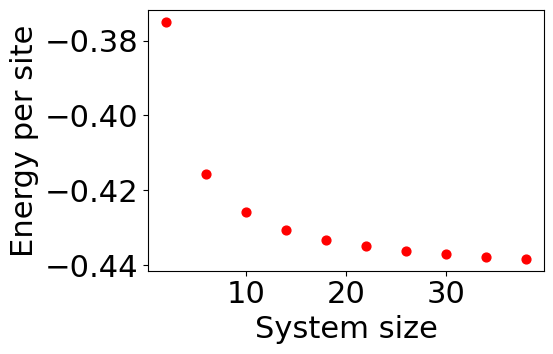

In [22]:
from dmrgpy import fermionchain

def get_energy(N):
    """Return energies for a system fo size N"""
    spins = ["S=1/2" for i in range(N)] # S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    J = 1. # exchange coupling
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    fc.set_hamiltonian(h) # set the Hamiltonian
    return fc.gs_energy(mode="DMRG")/N # energy per site

plt.figure(figsize=(6,4))

Ns = [i for i in range(2,40,4)] # lengths of the system
es = [get_energy(N) for N in Ns] # ground state energy per site

plt.scatter(Ns,es,s=40,c="red") # plot the energies

plt.xlabel("System size") ; plt.ylabel("Energy per site") ;  plt.tight_layout()

### Quiz
- Why does the energy per site depend on the system size
- What would be the value in the thermodynamic limit?
- What is the biggest system that you could compute with exact diagonalization?

## Charge expectation value for weak and strong interactions
We will now see what is the impact of electronic repulsion in a fermionic model

In [119]:
L = 100 # number of fermions

def get_den(V=0.):
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    m = 0.1 # pinning of the charge
    H = H + m*(fc.N[0] - fc.N[L-1]) # pin the CDW with a lagrange multiplier
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction
    fc.set_hamiltonian(H) # set the Hamiltonian
    fc.maxm = 20 # to accelerate the calculation
    wf0 = fc.get_gs(mode="DMRG")
    return [wf0.dot(Ni*wf0).real for Ni in fc.N] # magnetization in each site

den0 = get_den(V=1.) # compute charge density
den1 = get_den(V=4.) # compute charge density



Text(0, 0.5, '$\\langle c^\\dagger_n c_n \\rangle$')

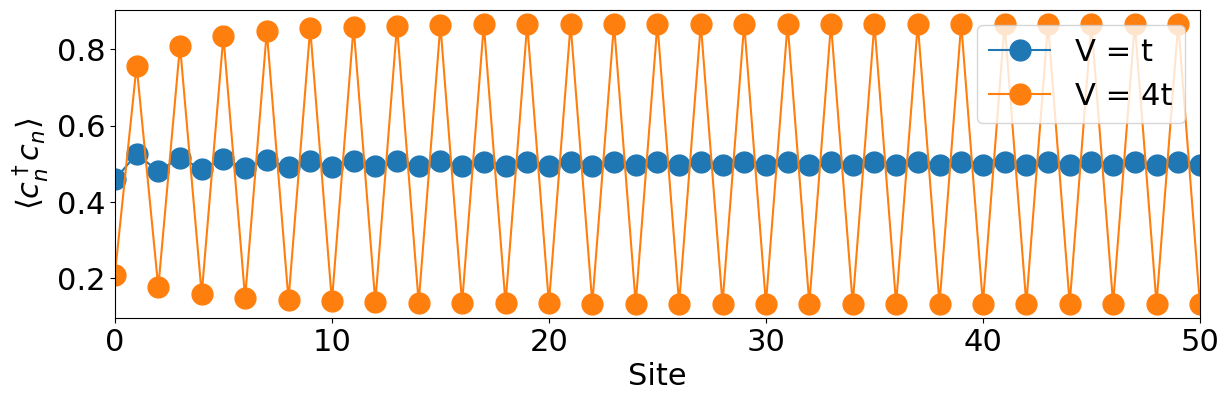

In [124]:
plt.figure(figsize=(14,4))

plt.plot(range(L),den0,label="V = t",marker="o",markersize=15)
plt.plot(range(L),den1,label="V = 4t",marker="o",markersize=15)
plt.legend() ; plt.xlim([0,L//2])
plt.xlabel("Site") ; plt.ylabel("$\\langle c^\\dagger_n c_n \\rangle$")

### Quiz
- Which phase is a charge density wave?
- Make the system smaller. What do you observe and why?

## Phase transition in a repulsive fermionic model
We will now see how we can observe a phase transition in an interacting fermionic model by looking at observables as a function of the interaction strength

Text(0, 0.5, '$V$')

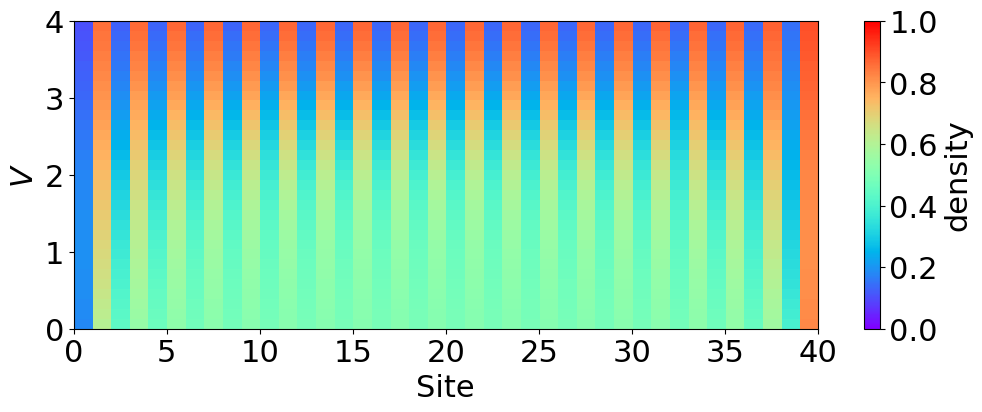

In [231]:
L = 40 # number of fermions

def get_den(V=0.):
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    m = 1.0 # pinning of the charge
    H = H + m*(fc.N[0] - fc.N[L-1]) # pin the CDW with a lagrange multiplier
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction
    fc.set_hamiltonian(H) # set the Hamiltonian
    fc.maxm = 20 # modest bond dimension to accelerate the calculation
    wf0 = fc.get_gs(mode="DMRG")
    return [wf0.dot(Ni*wf0).real for Ni in fc.N] # magnetization in each site

Vs = np.linspace(0.,4.,31,endpoint=True) # chemical potential
dens = [get_den(V) for V in Vs] # compute magnetizations

plt.figure(figsize=(12,4))

plt.imshow(list(reversed(dens)),aspect="auto",extent=[0,L,min(Vs),max(Vs)],vmin=0.,vmax=1.,cmap="rainbow")
plt.colorbar(label="density") ; plt.xlabel("Site") ; plt.ylabel("$V$")

### Quiz
- Why does the charge density decay towards the bulk at zero interaction?
- Where would you say that the phase transition is?
- Make the system smaller (L=10), what happens?

## Charge density in the presence of an impurity
Let us now look at the charge density int eh presence of an impurity

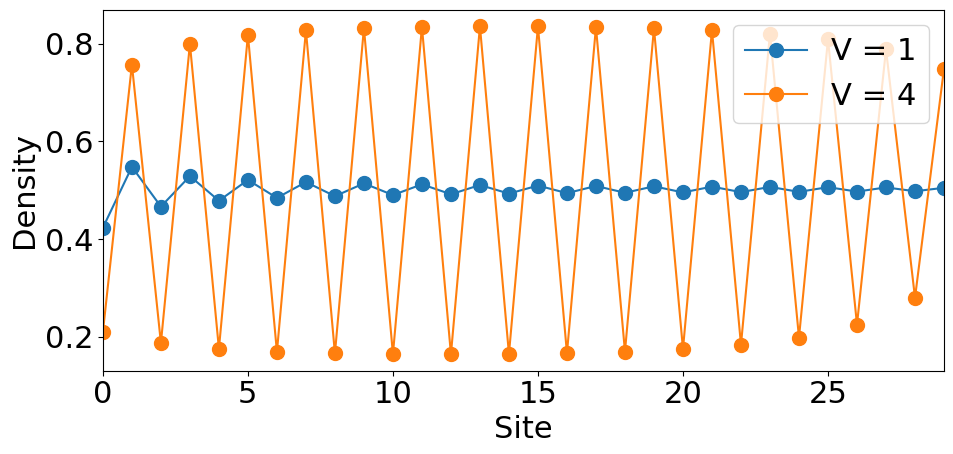

In [44]:
def get_charge(L=20,V=0.):
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    H = H + 0.2*fc.N[0] # local impurity
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction
    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="DMRG")
    return [wf0.dot(Ni*wf0) for Ni in fc.N] # return charge

L = 30 # length of the system


iis = range(L)    
plt.figure(figsize=(10,5))

Vs = [1,4] # strengths of the interaction
for V in Vs:
    ds = get_charge(L=L,V=V)
    plt.plot(iis,ds,marker="o",markersize=10,label="V = "+str(V))

plt.legend()
plt.xlabel("Site") ; plt.ylabel("Density") ; plt.xlim([min(iis),max(iis)])
plt.tight_layout()

### Quiz
- Why do the charge oscillations decay away fromt he impurity for V=1
- What does it mean that the charge oscillations do not decay away from the impurity for V=4
- Put the impurity in the middle instead of at the beginning, what do you observe and why?

## Non-local static correlators for the particle-particle response of a large interacting fermionic model
We will now see how the non-local static correlators hof the particle-particle response to see how the system becomes insulating

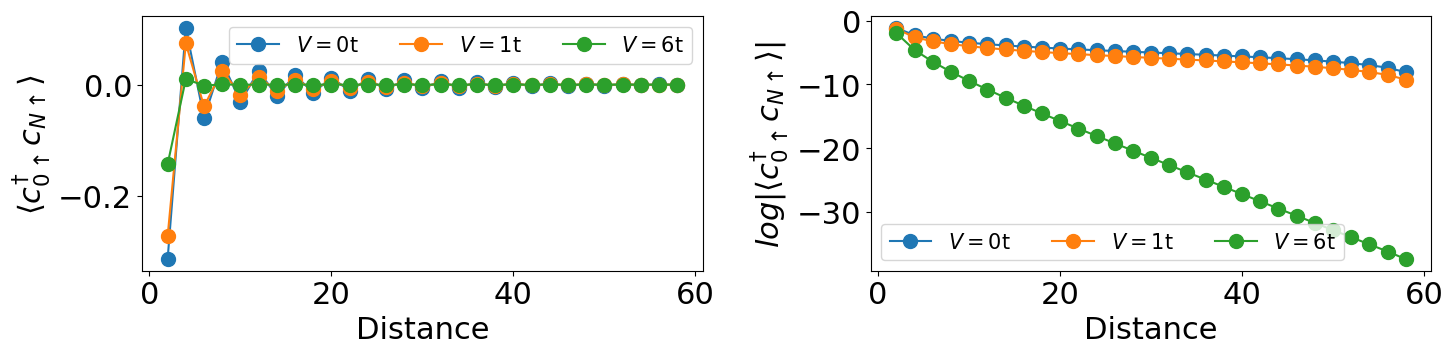

In [100]:
L = 60 # number of sites
isites = range(2,L,2) # only odd sites


def get_correlator(V=0.):
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    H = H + fc.N[0] # add an impurity at the beginning to pin the ground state
    for i in range(L-1): 
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction

    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="DMRG") # get ground state
    return [wf0.dot(fc.Cdag[1]*fc.C[i]*wf0).real for i in isites]



Vs = [0,1,6] # interactions
cijs = [get_correlator(V=V) for V in Vs] # store the correlators

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
for (V,cij) in zip(Vs,cijs):
    plt.plot(isites,cij,label="$V =$"+str(V)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$\\langle c^{\\dagger}_{1} c_{N} \\rangle $") 

plt.subplot(1,2,2)
for (V,cij) in zip(Vs,cijs):
    plt.plot(isites,np.log(np.abs(cij)),label="$V =$"+str(V)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$log |\\langle c^{\\dagger}_{1} c_{N} \\rangle |$") 

plt.tight_layout()

### Quiz
- Which systems are metalic and which are insulating?
- At which value of V does the system become insulating?

## Non-local pairing fluctuations of an attractive fermionic model
We will now see how an attractive fermionic model is susceptible to pairing

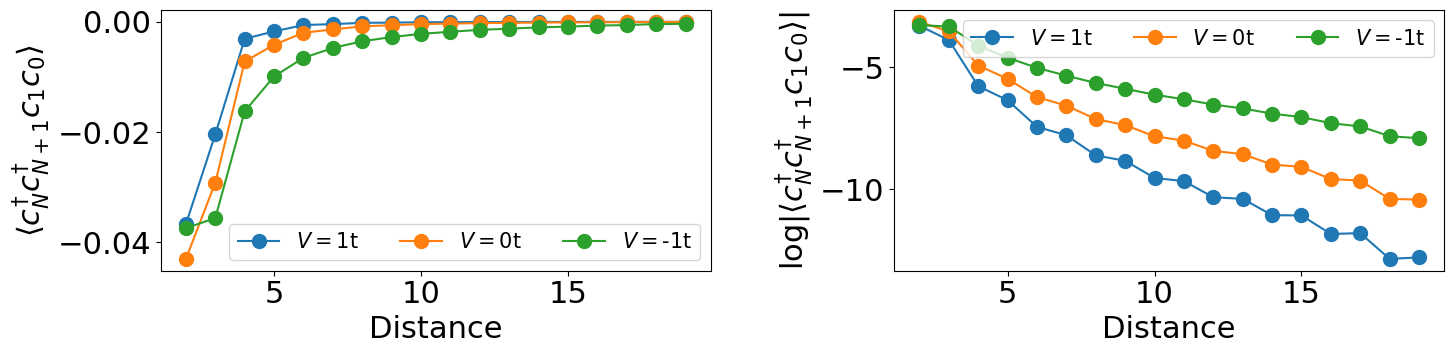

In [136]:
L = 20 # number of sites
isites = range(2,L,1) # only odd sites


def get_correlator(V=0.):
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    H = H + fc.N[0] # add an impurity at the beginning to pin the ground state
    for i in range(L-1): 
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction

    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="DMRG") # get ground state
    wf1 = fc.C[0]*fc.C[1]*wf0 # apply NN pairing 
    return [wf0.dot(fc.Cdag[i-1]*fc.Cdag[i]*wf1).real for i in isites]



Vs = [1,0,-1] # interactions
cijs = [get_correlator(V=V) for V in Vs] # store the correlators

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
for (V,cij) in zip(Vs,cijs):
    plt.plot(isites,cij,label="$V =$"+str(V)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
ylab = "$\\langle c^{\\dagger}_{N} c^{\\dagger}_{N+1} c_{1} c_{0} \\rangle $"
plt.xlabel("Distance") ; plt.ylabel(ylab) 

plt.subplot(1,2,2)
for (V,cij) in zip(Vs,cijs):
    plt.plot(isites,np.log(np.abs(cij)),label="$V =$"+str(V)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("log|"+ ylab + "|") 

plt.tight_layout()

### Quiz
- Which system is more susceptible to have pairing fluctuations?

## Non-local static correlators for the particle-particle response of a large Hubbard model
We will now see how the non-local static correlators hof the particle-particle response to see how the system becomes insulating

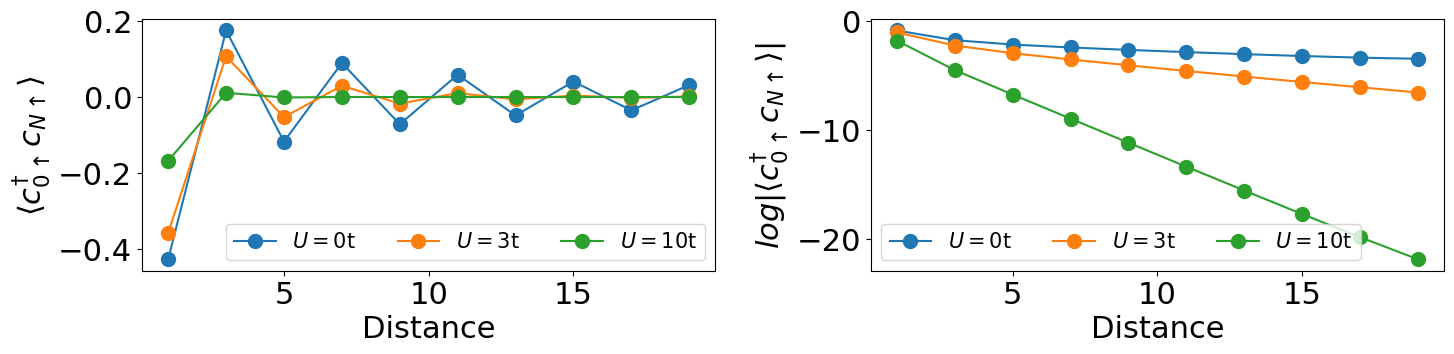

In [94]:
L = 20 # number of sites
isites = range(1,L,2) # only odd sites


def get_correlator(U=0.):
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate

    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction

    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="DMRG") # get ground state
    return [wf0.dot(fc.Cdagup[0]*fc.Cup[i]*wf0).real for i in isites]



Us = [0,3,10] # interactions
cijs = [get_correlator(U=U) for U in Us] # store the correlators

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
for (U,cij) in zip(Us,cijs):
    plt.plot(isites,cij,label="$U =$"+str(U)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$\\langle c^{\\dagger}_{0\\uparrow} c_{N\\uparrow} \\rangle $") 

plt.subplot(1,2,2)
for (U,cij) in zip(Us,cijs):
    plt.plot(isites,np.log(np.abs(cij)),label="$U =$"+str(U)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$log |\\langle c^{\\dagger}_{0\\uparrow} c_{N\\uparrow} \\rangle |$") 

plt.tight_layout()

### Quiz
- Which system is an insulator for single charge excitations?
- Use attractive interactions instead of repulsive, what do you observe and why?
- Compute the down-down correlator instead of up up, what do you observe, and why?

## Spin and charge correlator in the Hubbard model
We will now show how the particle and spin correlators in the Hubbard model shows drastically different behavior

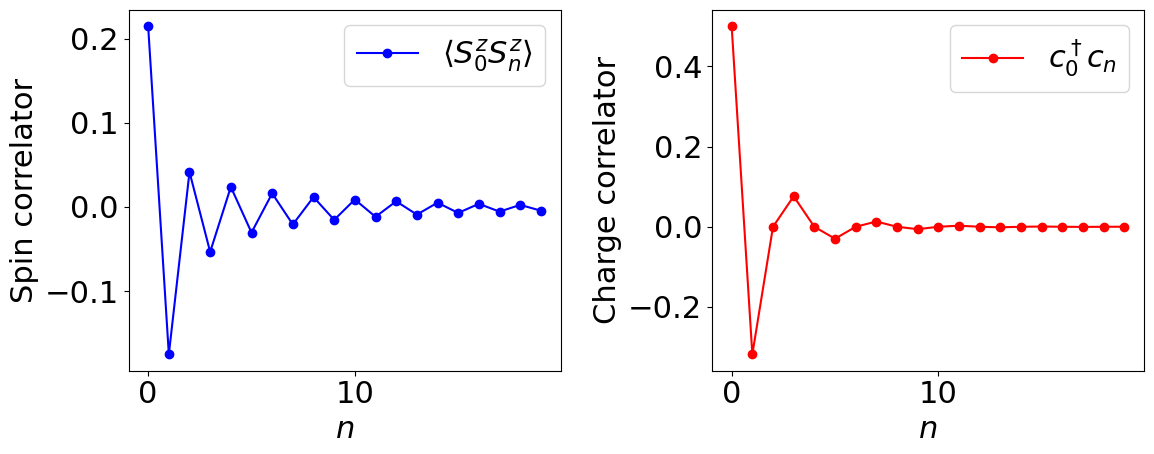

In [58]:
from dmrgpy import fermionchain
n = 20 # number of sites
fc = fermionchain.Spinful_Fermionic_Chain(n)
# first neighbor hopping
h = 0
for i in range(n-1):
    h = h + fc.Cdagup[i]*fc.Cup[i+1]
    h = h + fc.Cdagdn[i]*fc.Cdn[i+1]
h = h + h.get_dagger() # Make Hermitian
# Hubbard term
for i in range(n):
    h = h + 4.*(fc.Nup[i]-.5)*(fc.Ndn[i]-.5)
fc.set_hamiltonian(h) # initialize the Hamiltonian
# compute the particle and spin correlator
zz = [fc.vev(fc.Sz[0]*fc.Sz[i]).real for i in range(n)]
cc = [fc.vev(fc.Cdagup[0]*fc.Cup[i]).real for i in range(n)]

# now plot both
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(len(zz)),zz,marker="o",c="blue",label="$\langle S^z_0S^z_n\\rangle$")
plt.ylabel("Spin correlator")
plt.legend()
plt.xlabel("$n$")
plt.subplot(1,2,2)
plt.plot(range(len(cc)),cc,marker="o",c="red",label="$c^\dagger_0 c_n$")
plt.legend()
plt.ylabel("Charge correlator")
plt.xlabel("$n$")
#plt.xlim([-0.2,4])

plt.tight_layout()


### Quiz
- Can you guess the functional dependence of the two plots?
- Why does the spin correlator decay slowly?
- Why does the particle correlator decay very quickly?

## Spin-Spin non-local correlator of the Hubbard model

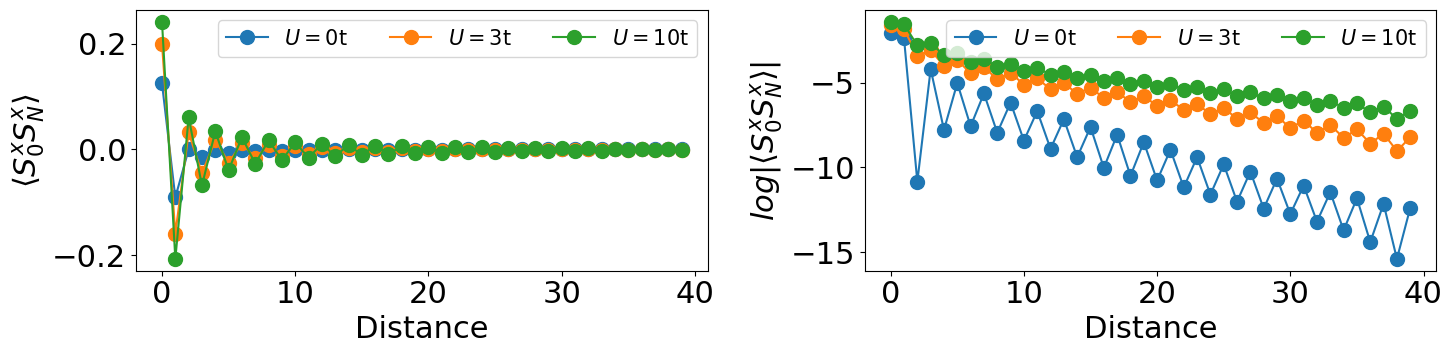

In [80]:
def get_correlator(U=0.):
    L = 40 # number of sites
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate

    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction

    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="DMRG") # get ground state
    return [wf0.dot(fc.Sx[0]*fc.Sx[i]*wf0).real for i in range(L)]



Us = [0,3,10] # interactions
cijs = [get_correlator(U=U) for U in Us] # store the correlators

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
for (U,cij) in zip(Us,cijs):
    plt.plot(range(len(cij)),cij,label="$U =$"+str(U)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$\\langle S_0^x S_N^x \\rangle $") 

plt.subplot(1,2,2)
for (U,cij) in zip(Us,cijs):
    plt.plot(range(len(cij)),np.log(np.abs(cij)),label="$U =$"+str(U)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$log |\\langle S_0^x S_N^x \\rangle |$") 

plt.tight_layout()

### Quiz
- What is the difference in the dependence in the interaction between the charge and spin correlations?
- Why does the non-local spin correlator get enhanced with the interaction
- Make the interaction attractive instead of repulsive. What happens, and why?

## Magnetic correlations in a dimerized Hubbard model
We will now see how a dimerization changes the spin correlation in the Hubbard model

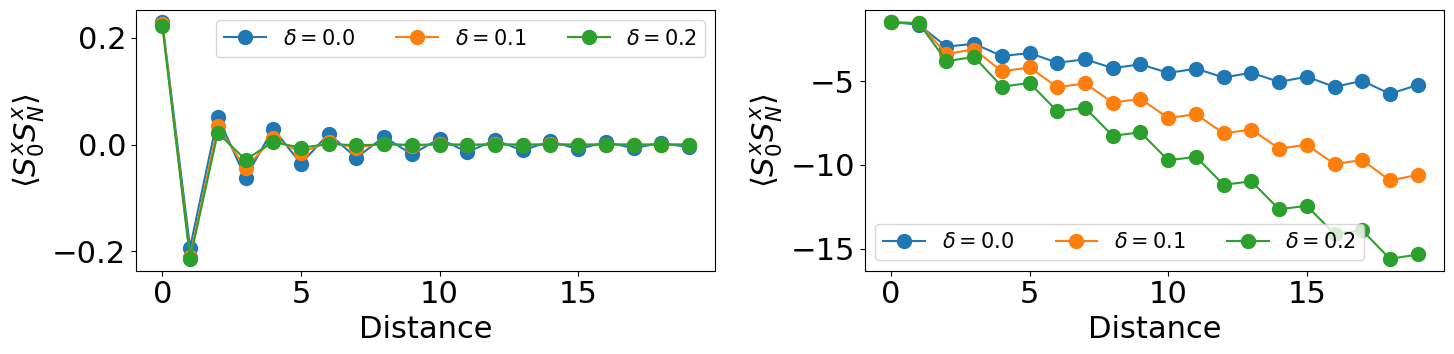

In [230]:
def get_correlator(U=0.,dt=0.):
    L = 20 # number of sites
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        t = 1 + dt*(-1)**i # dimerized hopping
        H = H + t*fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + t*fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate

    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction

    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="DMRG") # get ground state
    return [wf0.dot(fc.Sx[0]*fc.Sx[i]*wf0).real for i in range(L)]

U = 6.0 # large Hubbard interaction
dts = [0.,0.1,0.2] # second neighbor hopping
cijs = [get_correlator(U=U,dt=dt) for dt in dts] # store the correlators

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
for (dt,cij) in zip(dts,cijs):
    plt.plot(range(len(cij)),cij,label="$\\delta =$"+str(dt),marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$\\langle S_0^x S_N^x \\rangle $") 

plt.subplot(1,2,2)
for (dt,cij) in zip(dts,cijs):
    plt.plot(range(len(cij)),np.log(np.abs(cij)),label="$\\delta =$"+str(dt),marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$\\langle S_0^x S_N^x \\rangle $") 

plt.tight_layout()

### Quiz
- What is the impact that the dimerization has in the spin excitations?
- Remove the Hubbard interaction, what happens to the system, and why?

## Pairing correlators in the Hubbard model
We will now see how the pairing correlations change between attractive and repulsive interactions

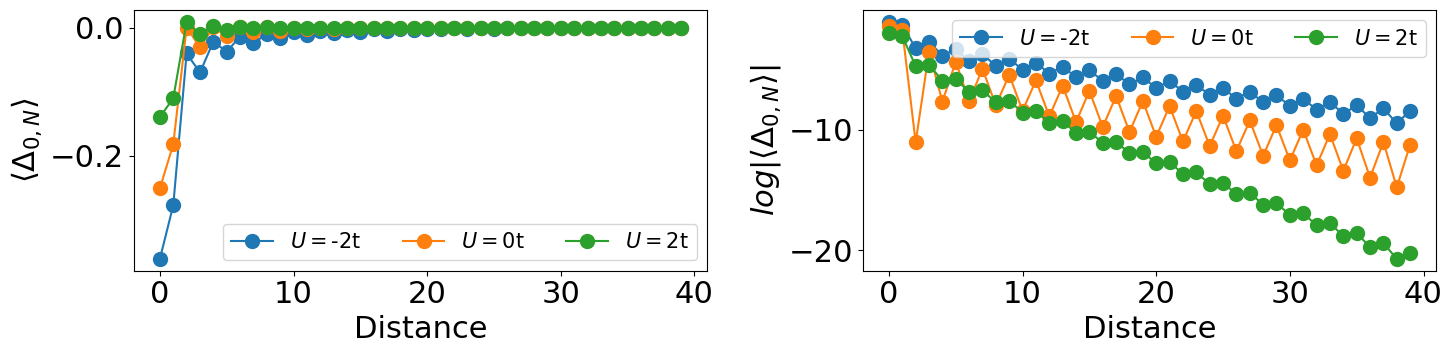

In [62]:
def get_correlator(U=0.):
    L = 40 # number of sites
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction
    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="DMRG") # get ground state
    wf1 = fc.Cdagup[0]*fc.Cdagdn[0]*wf0
    return [wf0.dot(fc.Cup[i]*fc.Cdn[i]*wf1).real for i in range(L)]



Us = [-2,0,2] # interactions
cijs = [get_correlator(U=U) for U in Us] # store the correlators

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
for (U,cij) in zip(Us,cijs):
    plt.plot(range(len(cij)),cij,label="$U =$"+str(U)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$\\langle \Delta_{0,N} \\rangle $") 

plt.subplot(1,2,2)
for (U,cij) in zip(Us,cijs):
    plt.plot(range(len(cij)),np.log(np.abs(cij)),label="$U =$"+str(U)+"t",marker="o",markersize=10)
plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$log |\\langle \Delta_{0,N}  \\rangle |$") 

plt.tight_layout()

### Quiz
- Which system is more susceptible to have pairing fluctuations, and why?


## The correlation entropy of an interacting fermionic model
We will now see how the correlation entropy of a fermionic model allows seeing which states can be described by mean field theory

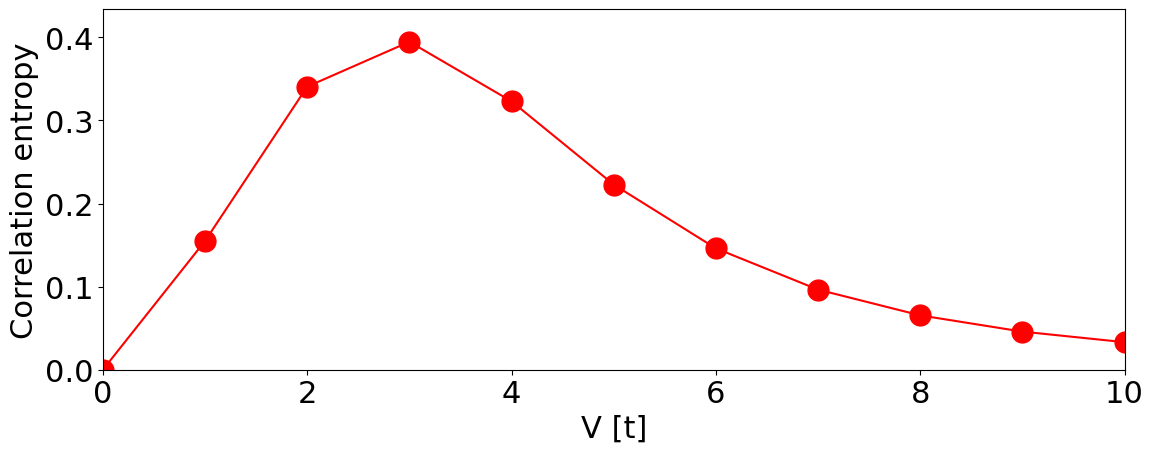

In [234]:
L = 10 # number of fermions

def get_ent(V=0.):
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    m = 1.0 # pinning of the charge
    H = H + m*(fc.N[0] - fc.N[L-1]) # pin the CDW with a lagrange multiplier
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction
    fc.set_hamiltonian(H) # set the Hamiltonian
    fc.maxm = 20 # to accelerate the calculation
    wf0 = fc.get_gs(mode="ED")
    return wf0.get_correlation_entropy()

Vs = np.linspace(0,10.,11,endpoint=True) # chemical potential
ents = [get_ent(V) for V in Vs] # compute magnetizations

plt.figure(figsize=(12,5))

plt.plot(Vs,ents,label="V = t",marker="o",markersize=15,c="red")
plt.xlabel("V [t]") ; plt.ylabel("Correlation entropy")
plt.xlim([min(Vs),max(Vs)]) ; plt.ylim([0,max(ents)*1.1]) 
plt.tight_layout()

### Quiz
- Which ground states can be described by a mean field variational state?
- Make the system smaller, what happens and why?

## From a quantum magnet to a symmetry broken mean field magnet
Let us now see how by adding a pinning field we can drive a quantum Hubbard magnet to the mean-field solution

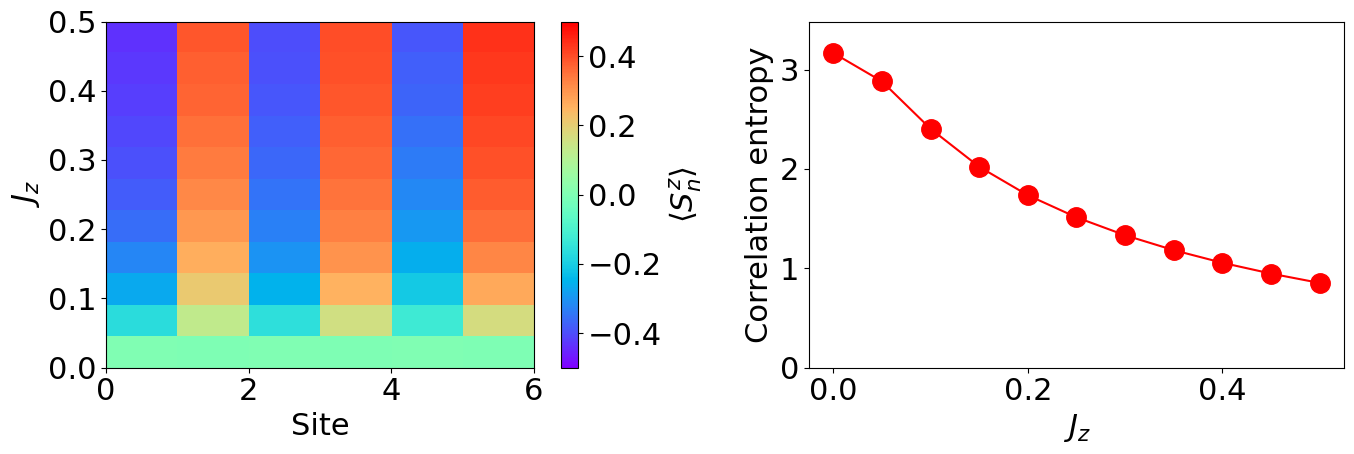

In [232]:
L = 6 # number of fermions

def get_mz(Jz=0.,U=0.):
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction
    for i in range(L): H = H + Jz*(-1)**i*fc.Sz[i] # add a stagger magnetic field
    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="ED") # get ground state
    mz = [wf0.dot(Szi*wf0).real for Szi in fc.Sz] # magnetization in each site
    return mz,wf0.get_correlation_entropy() # return magnetization and correlation entropy

Jzs = np.linspace(0.,0.5,11,endpoint=True) # magnetic field
U = 6.0 # interaction strength
outs = [get_mz(Jz=Jz,U=U) for Jz in Jzs] # compute magnetizations

mzs = [o[0] for o in outs] # magnetization
ents = [o[1] for o in outs] # entropies

plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.imshow(list(reversed(mzs)),aspect="auto",extent=[0,L,min(Jzs),max(Jzs)],vmin=-0.5,vmax=0.5,cmap="rainbow")
plt.colorbar(label="$\\langle S^z_n \\rangle$") ; plt.xlabel("Site") ; plt.ylabel("$J_z$")

plt.subplot(1,2,2)
plt.plot(Jzs,ents,marker="o",c="red",markersize=14)
plt.xlabel("$J_z$") ; plt.ylabel("Correlation entropy") ; plt.ylim([0,max(ents)*1.1])

plt.tight_layout()

### Quiz
- Why does the exchange field Jz drive the system to a state with lower correlation entropy?
- Increase the value of U, does the correlation entropy become smaller or bigger, and why is it?

## Correlation entropy of the Anderson model
We will now see how the correlation intropy is distributed around a correlated impurity in a metal

Text(0, 0.5, 'Local correlation entropy')

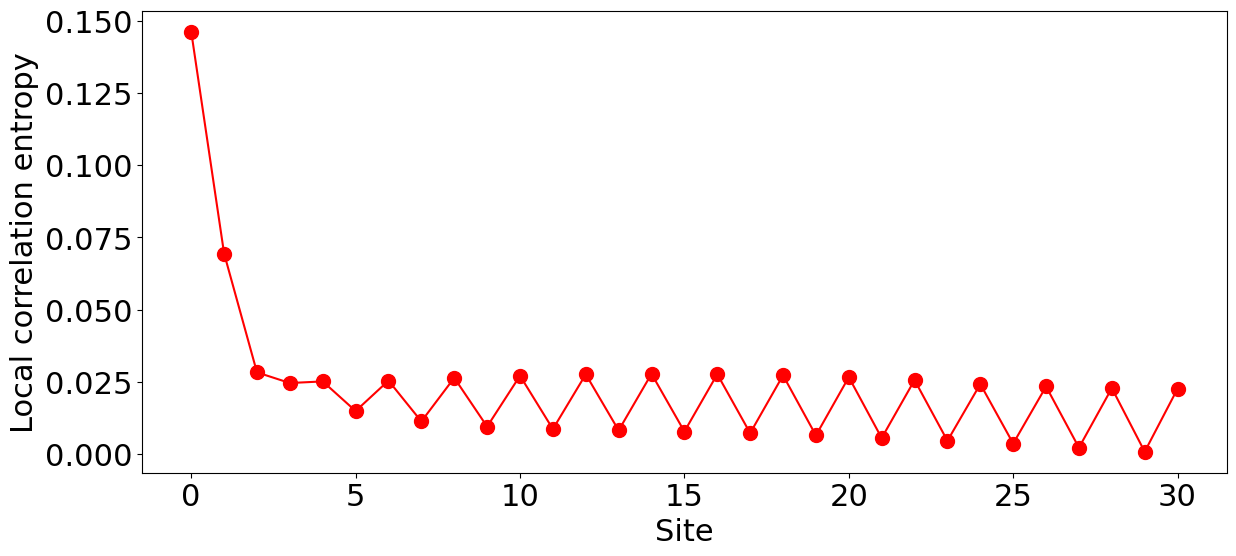

In [254]:
L = 31 # number of spinful fermionic sites
isite = 0 # impurity site

fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
H = 0 # initialize Hamiltonian
for i in range(L-1): # nearest neighbor hopping
    H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
    H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
H = H + H.get_dagger() # Hermitian conjugate
cdw = .0 # charge density order in the metal to open a gap
for i in range(L):
    if i!=isite: H = H + (-1)**i*cdw*(fc.Nup[i] + fc.Ndn[i]) # chemical potential in the metal

U = 2.0 # Hubbard interaction
Jz = .0 # local magnetic field in the impurity


H = H + U*(fc.Nup[isite]-0.5)*(fc.Ndn[isite]-0.5) # interaction int he middle site
H = H + Jz*fc.Sz[isite] # local field in the impurity

fc.set_hamiltonian(H) # set the Hamiltonian
wf0 = fc.get_gs(mode="DMRG") # get ground state
Ss = wf0.get_correlation_entropy_density() # correlation entropy in real space

plt.figure(figsize=(14,6))
plt.plot(range(len(Ss)),Ss,marker="o",markersize=10,c="red") # plot entropy density
plt.xlabel("Site") ; plt.ylabel("Local correlation entropy")

### Quiz
- Why is the correlation entropy large in the first site, and decays with distance?
- Create a gap in the metal by switching on the CDW, what happens to the correlation entropy, and why?